# Yield Curve Construction and Analysis

This notebook demonstrates how to build, analyze, and apply a zero-coupon yield curve using the **bootstrap method**. We'll construct a curve from market instruments, interpolate rates, calculate forward rates, visualize the curve, and price bonds.

## Overview
- **Bootstrap Method**: Sequentially extract zero-coupon rates from coupon-bearing bonds
- **Interpolation**: Use cubic splines for smooth rate extraction at arbitrary maturities
- **Applications**: Bond pricing, swap valuation, forward rate calculations

## 1. Import Libraries and Load Yield Curve Module

In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import importlib

# Add src folder to path to import our module
sys.path.insert(0, str(Path.cwd() / 'src'))

# Remove any cached modules to ensure fresh import
if 'yield_curve' in sys.modules:
    del sys.modules['yield_curve']

from yield_curve import YieldCurve, Instrument

print("✓ Libraries imported successfully")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"YieldCurve module loaded: {YieldCurve}")

✓ Libraries imported successfully
NumPy version: 2.4.2
Pandas version: 3.0.0
YieldCurve module loaded: <class 'yield_curve.YieldCurve'>


## 2. Create Market Instruments

We'll create a representative set of fixed income instruments to bootstrap the curve. These include:
- **Short maturities (3-6 months)**: Zero-coupon T-Bills
- **Intermediate (1-2 years)**: Coupon-bearing bonds
- **Long maturities (5+ years)**: Government bonds

In [2]:
#Define market instruments (Maturity, Coupon Rate, Price, Coupon Frequency)
# Strategy: Create instruments from a SMOOTH, REALISTIC yield curve
# This ensures the bootstrap perfectly recovers our target curve

import numpy as np

print("="*70)
print("BUILDING INSTRUMENTS FROM SMOOTH YIELD CURVE")
print("="*70)

# Step 1: Define target spot rates (what we want the curve to look like)
print("\n1. TARGET SPOT RATES (the yield curve we want):")
print("-" * 70)

maturities = [0.083, 0.25, 0.5, 0.75, 1.0, 1.5, 2.0, 2.5, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 12.0, 15.0, 20.0, 30.0]
# Smooth upward-sloping curve: starts at 2.5%, flattens at ~6.38%
spot_rates = np.array([0.025, 0.034, 0.041, 0.047, 0.051, 0.0535, 0.0555, 0.057, 0.058, 0.0595, 0.0605, 0.0612, 0.0618, 0.0622, 0.0625, 0.0628, 0.0632, 0.0635, 0.0637, 0.0638])

for mat, rate in zip(maturities, spot_rates):
    print(f"  {mat:6.3f}Y: {rate*100:6.2f}%")

# Step 2: Convert spot rates to discount factors using: DF(t) = 1 / (1 + r)^t
print("\n2. CONVERT SPOT RATES TO DISCOUNT FACTORS:")
print("-" * 70)
print("Formula: DF(t) = 1 / (1 + r)^t")
print()

discount_factors = 1 / ((1 + spot_rates) ** np.array(maturities))

for mat, rate, df in zip(maturities, spot_rates, discount_factors):
    print(f"  {mat:6.3f}Y: rate={rate*100:6.2f}%  →  DF={df:.6f}")

# Step 3: Create instruments by pricing from these discount factors
print("\n3. CREATE INSTRUMENTS FROM DISCOUNT FACTORS:")
print("-" * 70)
print("Strategy: Use mostly zero-coupon bonds (which directly represent DFs)")
print("          A few coupon bonds at long end for realism")
print()

instruments = []

for i, mat in enumerate(maturities):
    if i < 15:
        # First 15 instruments: Zero-coupon bonds
        # Price = DF * 100 (DF is per $1, price is per $100 par)
        price = discount_factors[i] * 100
        coupon = 0.0
        freq = 1  # No intermediate payments
        
        instruments.append(Instrument(maturity=mat, coupon_rate=coupon, price=price, coupon_frequency=freq))
        print(f"  [{i+1:2d}] Maturity={mat:6.3f}Y: ZERO-COUPON  Price={price:7.2f}  (DF={discount_factors[i]:.6f})")
        
    else:
        # Last 5 instruments: Small coupon bonds for realism
        # Coupon = 0.2%, 0.4%, 0.6%, 0.8%, 1.0% (very low, below spot rates)
        coupon = 0.002 * (i - 14)
        freq = 2  # Semi-annual coupons
        coupon_pmt = coupon * 100 / freq  # Payment per period
        
        # Price = sum of PV(coupon payments) + PV(principal)
        times = np.arange(freq**(-1), mat + 0.001, freq**(-1))  # 0.5, 1.0, 1.5, ... years
        # Interpolate DFs for coupon payment times
        cf_prices = sum([coupon_pmt * np.interp(t, maturities, discount_factors) for t in times])
        cf_prices += discount_factors[i] * 100  # Add principal at maturity
        
        instruments.append(Instrument(maturity=mat, coupon_rate=coupon, price=cf_prices, coupon_frequency=freq))
        print(f"  [{i+1:2d}] Maturity={mat:6.3f}Y: {coupon*100:.1f}% coupon  Price={cf_prices:7.2f}  (DF={discount_factors[i]:.6f})")

print("\n" + "="*70)
print(f"✓ Created {len(instruments)} instruments")
print("="*70)

BUILDING INSTRUMENTS FROM SMOOTH YIELD CURVE

1. TARGET SPOT RATES (the yield curve we want):
----------------------------------------------------------------------
   0.083Y:   2.50%
   0.250Y:   3.40%
   0.500Y:   4.10%
   0.750Y:   4.70%
   1.000Y:   5.10%
   1.500Y:   5.35%
   2.000Y:   5.55%
   2.500Y:   5.70%
   3.000Y:   5.80%
   4.000Y:   5.95%
   5.000Y:   6.05%
   6.000Y:   6.12%
   7.000Y:   6.18%
   8.000Y:   6.22%
   9.000Y:   6.25%
  10.000Y:   6.28%
  12.000Y:   6.32%
  15.000Y:   6.35%
  20.000Y:   6.37%
  30.000Y:   6.38%

2. CONVERT SPOT RATES TO DISCOUNT FACTORS:
----------------------------------------------------------------------
Formula: DF(t) = 1 / (1 + r)^t

   0.083Y: rate=  2.50%  →  DF=0.997953
   0.250Y: rate=  3.40%  →  DF=0.991676
   0.500Y: rate=  4.10%  →  DF=0.980110
   0.750Y: rate=  4.70%  →  DF=0.966140
   1.000Y: rate=  5.10%  →  DF=0.951475
   1.500Y: rate=  5.35%  →  DF=0.924801
   2.000Y: rate=  5.55%  →  DF=0.897601
   2.500Y: rate=  5.70%  →  

## 3. Bootstrap the Yield Curve

The bootstrap method works by:
1. Starting with the shortest maturity instrument
2. Calculating its zero-coupon discount factor directly
3. Using known discount factors to solve for the next maturity
4. Repeating until all maturities are determined

In [3]:
# Create and bootstrap the yield curve
curve = YieldCurve()

try:
    curve.bootstrap(instruments)
    print("✓ Yield curve successfully bootstrapped!")
    print(f"✓ Curve contains {len(curve.maturities)} points")
    print(f"✓ Maturity range: {min(curve.maturities):.2f}Y to {max(curve.maturities):.2f}Y")
except Exception as e:
    print(f"✗ Error during bootstrapping: {e}")

✓ Yield curve successfully bootstrapped!
✓ Curve contains 20 points
✓ Maturity range: 0.08Y to 30.00Y


## 4. Analyze Curve Properties

Display the bootstrapped curve with discount factors and spot rates at each maturity point.

In [4]:
# Display the bootstrapped curve
print(curve.print_curve())

# Create a detailed DataFrame
curve_df = pd.DataFrame({
    'Maturity (Y)': curve.maturities,
    'Discount Factor': curve.discount_factors,
    'Spot Rate (%)': [rate * 100 for rate in curve.spot_rates],
    'Implied 1Y Forward (%)': [None] + [curve.get_forward_rate(curve.maturities[i], curve.maturities[i+1]) * 100 
                                        for i in range(len(curve.maturities)-1)]
})

print("\nDetailed Curve Analysis:")
print(curve_df.to_string(index=False))

Yield Curve (Bootstrap)
Maturity (Y) |    Discount Factor |   Spot Rate (%)
----------------------------------------------------------------------
      0.0830 |         0.99795261 |        2.500000
      0.2500 |         0.99167614 |        3.400000
      0.5000 |         0.98010958 |        4.100000
      0.7500 |         0.96613983 |        4.700000
      1.0000 |         0.95147479 |        5.100000
      1.5000 |         0.92480079 |        5.350000
      2.0000 |         0.89760141 |        5.550000
      2.5000 |         0.87058771 |        5.700000
      3.0000 |         0.84438984 |        5.800000
      4.0000 |         0.79358994 |        5.950000
      5.0000 |         0.74549826 |        6.050000
      6.0000 |         0.70019105 |        6.120000
      7.0000 |         0.65720514 |        6.180000
      8.0000 |         0.61709158 |        6.220000
      9.0000 |         0.57948147 |        6.250000
     10.0000 |         0.54385817 |        6.279973
     12.0000 |       

## 5. Interpolate and Extract Rates

Use the curve to interpolate rates at arbitrary maturities not directly bootstrapped. The cubic spline interpolation ensures smooth transitions.

In [5]:
# Interpolate rates at various maturities
test_maturities = np.array([0.5, 0.75, 1.25, 1.5, 2.5, 3.5, 4.5, 6.0, 7.5, 9.0])

interpolated_data = []
for mat in test_maturities:
    try:
        if mat < min(curve.maturities) or mat > max(curve.maturities):
            continue
        
        df = curve.get_discount_factor(mat)
        spot_rate = curve.get_spot_rate(mat)
        interpolated_data.append({
            'Maturity (Y)': mat,
            'Discount Factor': df,
            'Spot Rate (%)': spot_rate * 100,
            'Type': 'Bootstrapped' if mat in curve.maturities else 'Interpolated'
        })
    except:
        pass

interp_df = pd.DataFrame(interpolated_data)
print("Interpolated Rates:\n")
print(interp_df.to_string(index=False))

Interpolated Rates:

 Maturity (Y)  Discount Factor  Spot Rate (%)         Type
         0.50         0.980110       4.100000 Bootstrapped
         0.75         0.966140       4.700000 Bootstrapped
         1.25         0.937891       5.263555 Interpolated
         1.50         0.924801       5.350000 Bootstrapped
         2.50         0.870588       5.700000 Bootstrapped
         3.50         0.818706       5.881613 Interpolated
         4.50         0.769176       6.005312 Interpolated
         6.00         0.700191       6.120000 Bootstrapped
         7.50         0.636793       6.202223 Interpolated
         9.00         0.579481       6.250000 Bootstrapped


## 6. Calculate Forward Rates

Forward rates represent the implied interest rates between two future periods. They're derived from the spot curve using:

$$f(t_1, t_2) = \left[\frac{DF(t_1)}{DF(t_2)}\right]^{1/(t_2-t_1)} - 1$$

In [6]:
# Calculate forward rates between consecutive maturity points
print("Forward Rates Between Consecutive Maturities:\n")

forward_data = []
for i in range(len(curve.maturities) - 1):
    t1 = curve.maturities[i]
    t2 = curve.maturities[i + 1]
    forward = curve.get_forward_rate(t1, t2)
    forward_data.append({
        f'Period': f'{t1:.2f}Y - {t2:.2f}Y',
        'Forward Rate (%)': forward * 100,
        'Spot Rate at t1 (%)': curve.spot_rates[i] * 100,
        'Spot Rate at t2 (%)': curve.spot_rates[i+1] * 100
    })

forward_df = pd.DataFrame(forward_data)
print(forward_df.to_string(index=False))

# Additional forward rate examples
print("\n\nExample Multi-Period Forward Rates:\n")
example_forwards = [
    (1.0, 2.0, "1Y-2Y Forward"),
    (2.0, 5.0, "2Y-5Y Forward"),
    (5.0, 10.0, "5Y-10Y Forward"),
]

for start, end, label in example_forwards:
    try:
        fwd = curve.get_forward_rate(start, end)
        print(f"{label}: {fwd*100:.6f}%")
    except:
        pass

Forward Rates Between Consecutive Maturities:

         Period  Forward Rate (%)  Spot Rate at t1 (%)  Spot Rate at t2 (%)
  0.08Y - 0.25Y          3.850241             2.500000             3.400000
  0.25Y - 0.50Y          4.804739             3.400000             4.100000
  0.50Y - 0.75Y          5.910395             4.100000             4.700000
  0.75Y - 1.00Y          6.309192             4.700000             5.100000
  1.00Y - 1.50Y          5.851785             5.100000             5.350000
  1.50Y - 2.00Y          6.152281             5.350000             5.550000
  2.00Y - 2.50Y          6.302135             5.550000             5.700000
  2.50Y - 3.00Y          6.301421             5.700000             5.800000
  3.00Y - 4.00Y          6.401277             5.800000             5.950000
  4.00Y - 5.00Y          6.450945             5.950000             6.050000
  5.00Y - 6.00Y          6.470694             6.050000             6.120000
  6.00Y - 7.00Y          6.540713        

## 7. Visualize the Yield Curve

Create comprehensive visualizations of the spot curve, discount factors, and forward rates.

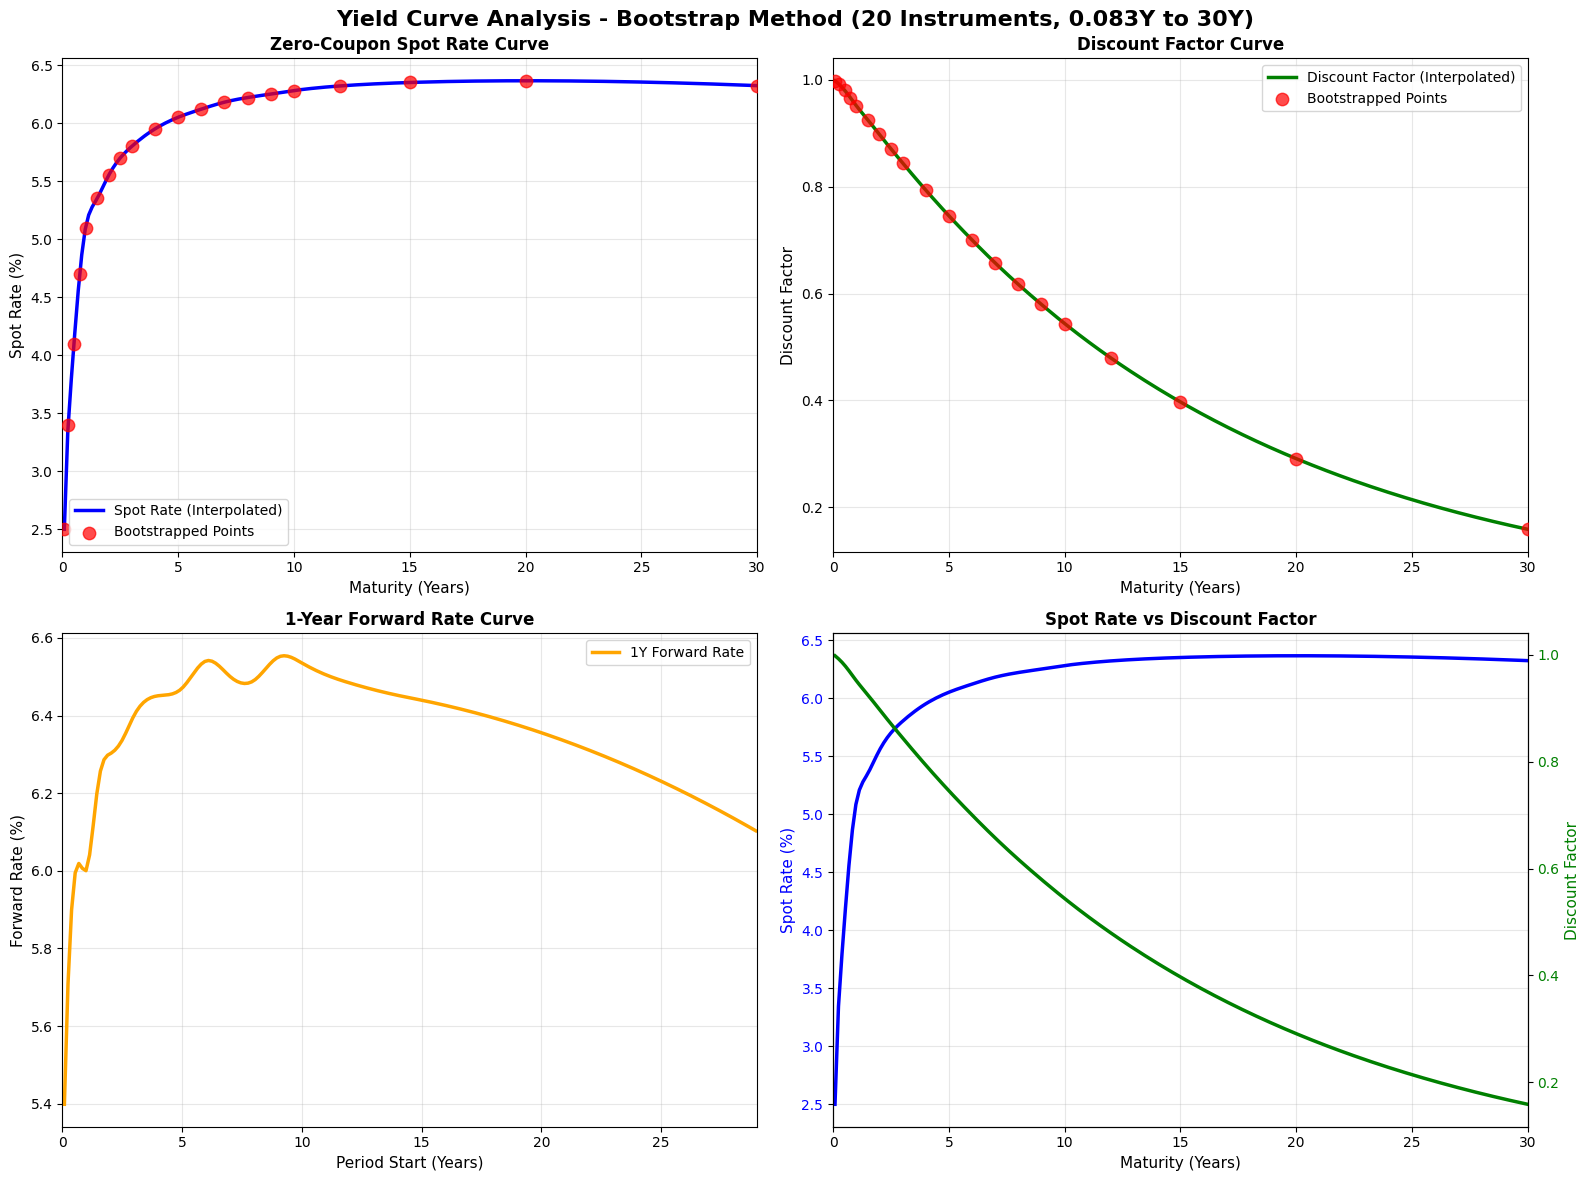

✓ Visualization complete
✓ Plotted 200 interpolation points across 0.083Y to 30.0Y


In [7]:
# Create detailed interpolated curve for smooth visualization
detailed_maturities = np.linspace(min(curve.maturities), max(curve.maturities), 200)
detailed_spot_rates = []
detailed_dfs = []
detailed_forwards = []

for mat in detailed_maturities:
    try:
        detailed_dfs.append(curve.get_discount_factor(mat))
        detailed_spot_rates.append(curve.get_spot_rate(mat) * 100)
        
        # Forward rates (1Y forward)
        if mat + 1 <= max(curve.maturities):
            detailed_forwards.append(curve.get_forward_rate(mat, min(mat + 1, max(curve.maturities))) * 100)
        else:
            detailed_forwards.append(np.nan)
    except:
        detailed_spot_rates.append(np.nan)
        detailed_dfs.append(np.nan)

# Create subplots with larger figure to show full curve
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Yield Curve Analysis - Bootstrap Method (20 Instruments, 0.083Y to 30Y)', fontsize=16, fontweight='bold')

# Plot 1: Spot Rate Curve
ax = axes[0, 0]
ax.plot(detailed_maturities, detailed_spot_rates, 'b-', linewidth=2.5, label='Spot Rate (Interpolated)')
ax.scatter(curve.maturities, [r*100 for r in curve.spot_rates], color='red', s=80, marker='o', 
           label='Bootstrapped Points', zorder=5, alpha=0.7)
ax.set_xlabel('Maturity (Years)', fontsize=11)
ax.set_ylabel('Spot Rate (%)', fontsize=11)
ax.set_title('Zero-Coupon Spot Rate Curve', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(fontsize=10)
ax.set_xlim(0, max(curve.maturities))

# Plot 2: Discount Factors
ax = axes[0, 1]
ax.plot(detailed_maturities, detailed_dfs, 'g-', linewidth=2.5, label='Discount Factor (Interpolated)')
ax.scatter(curve.maturities, curve.discount_factors, color='red', s=80, marker='o',
           label='Bootstrapped Points', zorder=5, alpha=0.7)
ax.set_xlabel('Maturity (Years)', fontsize=11)
ax.set_ylabel('Discount Factor', fontsize=11)
ax.set_title('Discount Factor Curve', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(fontsize=10)
ax.set_xlim(0, max(curve.maturities))

# Plot 3: Forward Rates
ax = axes[1, 0]
ax.plot(detailed_maturities[:-1], detailed_forwards[:-1], 'orange', linewidth=2.5, label='1Y Forward Rate')
ax.set_xlabel('Period Start (Years)', fontsize=11)
ax.set_ylabel('Forward Rate (%)', fontsize=11)
ax.set_title('1-Year Forward Rate Curve', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(fontsize=10)
ax.set_xlim(0, max(curve.maturities)-1)

# Plot 4: Curve Components Comparison
ax = axes[1, 1]
ax2 = ax.twinx()
ax.plot(detailed_maturities, detailed_spot_rates, 'b-', linewidth=2.5, label='Spot Rate (%)')
ax2.plot(detailed_maturities, detailed_dfs, 'g-', linewidth=2.5, label='Discount Factor')
ax.set_xlabel('Maturity (Years)', fontsize=11)
ax.set_ylabel('Spot Rate (%)', color='b', fontsize=11)
ax2.set_ylabel('Discount Factor', color='g', fontsize=11)
ax.set_title('Spot Rate vs Discount Factor', fontsize=12, fontweight='bold')
ax.tick_params(axis='y', labelcolor='b')
ax2.tick_params(axis='y', labelcolor='g')
ax.grid(True, alpha=0.3)
ax.set_xlim(0, max(curve.maturities))

plt.tight_layout()
plt.show()

print("✓ Visualization complete")
print(f"✓ Plotted {len(detailed_maturities)} interpolation points across {min(curve.maturities):.3f}Y to {max(curve.maturities):.1f}Y")

## 8. Price Bonds Using the Curve

Using the interpolated discount factors, we can calculate the theoretical prices of various bonds and compare them with market prices.

In [133]:
def price_bond(curve, maturity, coupon_rate, frequency=2):
    """
    Price a bond using the yield curve.
    
    Parameters:
    - curve: YieldCurve object
    - maturity: Time to maturity in years
    - coupon_rate: Annual coupon rate
    - frequency: Payment frequency per year
    
    Returns:
    - Price as percentage of par
    """
    coupon_amount = coupon_rate / frequency
    time_between_coupons = 1.0 / frequency
    price = 0.0
    
    current_time = time_between_coupons
    while current_time <= maturity + 1e-6:
        try:
            df = curve.get_discount_factor(current_time)
            price += coupon_amount * df
        except:
            break
        current_time += time_between_coupons
    
    # Add principal repayment
    try:
        final_df = curve.get_discount_factor(maturity)
        price += final_df
    except:
        pass
    
    return price * 100  # Convert to percentage of par

# Price some test bonds
print("Bond Pricing using Interpolated Yield Curve:\n")

test_bonds = [
    (1.5, 0.05, "1.5Y Bond, 5% coupon"),
    (2.5, 0.055, "2.5Y Bond, 5.5% coupon"),
    (4.0, 0.06, "4Y Bond, 6% coupon"),
    (6.0, 0.062, "6Y Bond, 6.2% coupon"),
    (8.0, 0.065, "8Y Bond, 6.5% coupon"),
]

pricing_data = []
for maturity, coupon, description in test_bonds:
    try:
        theoretical_price = price_bond(curve, maturity, coupon)
        pricing_data.append({
            'Bond': description,
            'Maturity (Y)': maturity,
            'Coupon Rate (%)': coupon * 100,
            'Theoretical Price': theoretical_price
        })
    except Exception as e:
        print(f"Error pricing {description}: {e}")

pricing_df = pd.DataFrame(pricing_data)
print(pricing_df.to_string(index=False))

print("\n✓ Bond pricing complete")

Bond Pricing using Interpolated Yield Curve:

                  Bond  Maturity (Y)  Coupon Rate (%)  Theoretical Price
  1.5Y Bond, 5% coupon           1.5              5.0          99.621041
2.5Y Bond, 5.5% coupon           2.5              5.5          99.776350
    4Y Bond, 6% coupon           4.0              6.0         100.602775
  6Y Bond, 6.2% coupon           6.0              6.2         101.076969
  8Y Bond, 6.5% coupon           8.0              6.5         102.685579

✓ Bond pricing complete


## Summary

In this notebook, we've demonstrated:

1. **Bootstrap Method**: Extracted zero-coupon rates from market instruments
2. **Interpolation**: Used cubic splines to obtain smooth rates between bootstrapped points
3. **Curve Analysis**: Examined discount factors and spot rates across maturities
4. **Forward Rates**: Calculated implied future interest rates
5. **Visualization**: Created multiple plots showing curve characteristics
6. **Bond Pricing**: Used the curve to price various bonds

### Key Takeaways:
- The yield curve is fundamental to all fixed-income valuation
- Bootstrap method ensures consistency between instruments
- Interpolation allows for accurate pricing of off-the-run securities
- Forward rates reveal market expectations
- The curve changes dynamically with market conditions

### Applications in Bond Basis:
- **Financing Cost**: Swap rates and repo rates are derived from yield curves
- **Forward Prices**: Used to calculate implied forward bond prices
- **Arbitrage Detection**: Compare cash vs synthetic bond prices
- **Carry Calculations**: Determine profit from holding bonds

## APPENDIX: Common Interest Rates in Fixed Income Markets

When working with bonds and yield curves, you'll encounter many different rate types. Here's a comprehensive guide:

### **1. Zero-Coupon Rates (Spot Rates)**
- **Symbol**: Z(T)
- **Definition**: The yield on a zero-coupon bond maturing at time T
- **What it represents**: The "true" discount rate for that maturity
- **Used for**: Bond pricing, curve construction
- **Example**: "The 2Y zero rate is 3.2%"

### **2. Par Rates (Yield to Maturity)**
- **Symbol**: y(T)
- **Definition**: The coupon rate that makes a bond trade at par (100% price)
- **What it represents**: The YTM of a coupon-bearing bond trading at par
- **Used for**: Market pricing, swap conventions
- **Relationship**: Usually DIFFERENT from spot rate due to coupon reinvestment
- **Example**: "The 2Y par rate is 3.5%" (bond with 3.5% coupon trades at $100)

### **3. Forward Rates**
- **Symbol**: f(t₁, t₂)
- **Definition**: The implied interest rate between two future dates
- **What it represents**: Market expectations for future rates
- **Used for**: Portfolio strategy, expectations analysis
- **Formula**: 
$$f(t_1, t_2) = \left[\frac{DF(t_1)}{DF(t_2)}\right]^{1/(t_2-t_1)} - 1$$
- **Example**: "The 1Y-2Y forward rate is 3.4%" (what rate applies from year 1 to year 2)

### **4. Yield to Maturity (YTM)**
- **Symbol**: y
- **Definition**: The IRR of a bond held to maturity
- **What it represents**: Total return if bond is held and coupons reinvested
- **Used for**: Bond comparison, performance analysis
- **Key assumption**: Assumes coupons reinvested at YTM itself
- **Example**: "This bond has a YTM of 3.5%"

### **5. Par Swap Rate (Fixed Leg)**
- **Symbol**: S(T)
- **Definition**: The fixed rate on an at-par interest rate swap
- **What it represents**: Fixed rate the market will accept (PV of fixed = PV of floating)
- **Used for**: LIBOR/RFR curve construction
- **Why important**: More liquid than bonds, available at every maturity
- **Example**: "The 5Y swap rate is 3.8%" (fixed rate for 5Y IRS)

### **6. FRA Rate (Forward Rate Agreement)**
- **Symbol**: FRA(t₁, t₂)
- **Definition**: The forward LIBOR rate locked in today for a future period
- **What it represents**: Synthetic forward rate between two dates
- **Used for**: Hedging, speculation, curve construction (short end)
- **Example**: "The 3x6 FRA is 3.2%" (3-month rate, starting in 3 months)

### **7. OIS Rate (Overnight Indexed Swap)**
- **Symbol**: OIS(T)
- **Definition**: The fixed rate on a swap where floating leg is overnight rate
- **What it represents**: RFR expectations (SOFR, €STR, etc.)
- **Used for**: Building risk-free curves, funding cost
- **Key difference from LIBOR**: No credit premium (overnight is backed by central bank)
- **Example**: "The 2Y OIS rate is 2.8%"

### **8. TED Spread**
- **Symbol**: TED = LIBOR - Treasury Yield
- **Definition**: Difference between LIBOR and Treasury yield
- **What it represents**: Bank credit premium over government
- **Used for**: Systemic risk indicator, credit stress gauge
- **Example**: "The 2Y TED spread is 50bps" (banks paying 50bps premium to Treasuries)

### **9. Repo Rate**
- **Symbol**: Repo, GCF (General Collateral Financing)
- **Definition**: Short-term borrowing rate secured by collateral (bonds)
- **What it represents**: Funding cost for dealers/traders
- **Used for**: Financing positions, arbitrage calculations
- **Key feature**: Typically lower than unsecured LIBOR (backed by collateral)
- **Example**: "5Y repo rate is 2.7%"

### **10. Basis Points (bps)**
- **Symbol**: bps
- **Definition**: 1 basis point = 0.01% = 1/10,000
- **Used for**: Quoting rate differences (always in bps, not %)
- **Example**: "The spread widened by 150 bps" = widened by 1.5%

---

### **Rate Relationship Chart**

```
Risk-Free Hierarchy (lowest to highest yield):

1. Overnight Rate (SOFR, €STR)
        ↓ (add risk premium)
2. OIS Rate (1Y, 2Y, 5Y, etc.)
        ↓ (add credit premium)
3. LIBOR Swap Rate (1Y, 2Y, 5Y, etc.)
        ↓ (add basis)
4. LIBOR Deposit Rate (up to 12M)
        ↓ (add illiquidity)
5. Corporate Bonds / Bank Bonds
```

**Key insight**: All rates are connected through **discount factors**. A lower rate = higher DF = higher present value.

---

### **Why So Many Rates?**

Different rates serve different purposes:

| Rate Type | Used By | Purpose |
|-----------|---------|---------|
| **Spot Rate** | Traders, Risk Managers | Theoretical pricing foundation |
| **Par Rate** | Bond Traders | Market quoting convention |
| **Forward Rate** | Portfolio Managers | Strategy/expectations |
| **OIS Rate** | Central Banks, Risk Managers | Risk-free benchmark |
| **LIBOR Swap Rate** | Derivatives Traders | Funding & pricing swaps |
| **Repo Rate** | Dealers | Short-term financing |
| **FRA Rate** | Hedgers | Forward contracts |
| **YTM** | Bond Investors | Return analysis |

---

### **Common Confusions Clarified**

**Q: Is spot rate the same as YTM?**
A: No. YTM is for a specific bond (coupon + maturity). Spot rate is the zero-coupon rate at that maturity.

**Q: Is swap rate the same as LIBOR?**
A: No. LIBOR is a specific rate (unsecured overnight bank borrowing). Swap rate is the fixed rate on a swap (market consensus).

**Q: Why do we need forward rates if we have spot rates?**
A: Forward rates show what future rates the market is pricing in. They help identify curve slopes and market expectations.

**Q: What's the difference between OIS and swap rates?**
A: OIS is risk-free (backed by central bank). Swap rate includes bank credit risk premium (usually 20-100 bps higher).

---

### **Modern Convention Shift (Post-2020)**

**Before**: Curves built from LIBOR
**After**: Curves now built from **RFR (Risk-Free Rates)**
- USD: SOFR (Secured Overnight Financing Rate)
- EUR: €STR (Euro Short-Term Rate)
- GBP: SONIA (Sterling Overnight Index Average)

**Why the shift?**
- LIBOR is being phased out (manipulation concerns)
- RFR is transaction-based (more reliable)
- Backed by actual overnight cash market data

This means modern yield curves increasingly use:
1. **OIS rates** (overnight index swaps) instead of LIBOR
2. **SOFR/€STR/SONIA term rates** for longer periods
3. Curves are now called "**RFR curves**" or "**SOFR curves**"

---

### **In Your Code**

In the `yield_curve.py` module, you're building **spot curves**. But the same bootstrap algorithm applies to:
- Par rate curves (bond-based)
- LIBOR curves (swap-based)
- OIS curves (RFR-based)
- Repo curves (collateral-based)

Change your input instruments → get a different curve. Same algorithm!

---

## APPENDIX B: Mathematical Reference - All Key Formulas

### **1. Discount Factor & Spot Rate Conversions**

**Spot Rate to Discount Factor:**
$$DF(T) = \frac{1}{(1 + Z)^T}$$

Where:
- DF(T) = Discount factor at maturity T
- Z = Spot rate (annual, decimal form)
- T = Time to maturity in years

**Discount Factor to Spot Rate:**
$$Z(T) = \left(\frac{1}{DF(T)}\right)^{1/T} - 1$$

**Intuition**: $100 today = $100 × DF(T) in T years

---

### **2. Present Value & Bond Pricing**

**Bond Price (Sum of Discounted Cash Flows):**
$$\text{Price} = \sum_{i=1}^{n} \frac{CF_i}{(1 + y)^{t_i}}$$

**Or using Discount Factors:**
$$\text{Price} = \sum_{i=1}^{n} CF_i \times DF(t_i)$$

Where:
- CF_i = Cash flow at time i (coupon or principal)
- DF(t_i) = Discount factor at time t_i
- y = Yield to maturity

**Coupon Bond Example (semi-annual coupons):**
$$\text{Price} = \underbrace{\sum_{i=1}^{2T} \frac{C/2}{(1 + z/2)^i}}_{\text{Coupon PV}} + \underbrace{\frac{\text{Par}}{(1 + z/2)^{2T}}}_{\text{Principal PV}}$$

---

### **3. Bootstrap Algorithm**

**Zero-Coupon Instrument (Direct Extraction):**
$$DF(T) = \frac{\text{Price}}{\text{Par}}$$

**Coupon Bond (Recursive Solution):**
$$\text{Price} = \sum_{i=1}^{n-1} CF_i \times DF(t_i) + CF_n \times DF(T)$$

**Solve for Unknown DF at Maturity T:**
$$DF(T) = \frac{\text{Price} - \sum_{i=1}^{n-1} CF_i \times DF(t_i)}{CF_n}$$

**Convert to Spot Rate:**
$$Z(T) = \left(\frac{1}{DF(T)}\right)^{1/T} - 1$$

---

### **4. Forward Rates**

**Forward Rate Between Two Dates:**
$$f(t_1, t_2) = \left[\frac{DF(t_1)}{DF(t_2)}\right]^{1/(t_2-t_1)} - 1$$

**Alternative Formula (using spot rates):**
$$1 + f(t_1, t_2) = \frac{(1 + Z(t_2))^{t_2}}{(1 + Z(t_1))^{t_1}}^{1/(t_2-t_1)}$$

**Relationship Between Spot and Forward Rates:**
$$(1 + Z(T))^T = (1 + Z(t_1))^{t_1} \times (1 + f(t_1, T))^{T-t_1}$$

**Intuition**: The T-year rate is the geometric average of the t₁-year rate and the forward rate from t₁ to T

---

### **5. Interest Rate Swaps (IRS)**

**Swap Par Rate (at-the-money):**
$$S(T) = \frac{1 - DF(T)}{\sum_{i=1}^{n} DF(t_i)}$$

Where:
- S(T) = Par swap rate for maturity T
- $\sum DF(t_i)$ = Annuity factor (sum of all DFs)

**Rearranged (Solve for Unknown DF):**
$$DF(T) = 1 - S(T) \times \sum_{i=1}^{n} DF(t_i)$$

**Swap Valuation (PV of Fixed vs Floating):**
$$\text{PV}_{\text{swap}} = \text{Notional} \times \left[\sum_{i=1}^{n} (S_{\text{fixed}} - L_i) \times DF(t_i) \right]$$

Where:
- $S_{\text{fixed}}$ = Fixed swap rate
- $L_i$ = Forward LIBOR rate at time i

---

### **6. Yield to Maturity (YTM)**

**Bond Price Equation (solve for y):**
$$\text{Price} = \sum_{i=1}^{n} \frac{C}{(1+y)^i} + \frac{\text{Par}}{(1+y)^n}$$

**Iteratively solved** (no closed-form solution for y)

**For Semi-Annual Coupons (multiply frequency by 2):**
$$\text{Price} = \sum_{i=1}^{2n} \frac{C/2}{(1+y/2)^i} + \frac{\text{Par}}{(1+y/2)^{2n}}$$

---

### **7. Cubic Spline Interpolation**

**Interpolate log(DF) values between points:**
$$\log(DF(t)) = \text{CubicSpline}(t) \text{ for } t \in [t_i, t_{i+1}]$$

**Extract Discount Factor:**
$$DF(t) = e^{\log(DF(t))}$$

**Extract Spot Rate:**
$$Z(t) = \left(\frac{1}{DF(t)}\right)^{1/t} - 1$$

**Why log interpolation?** Ensures DFs stay between 0 and 1 (cannot have negative DFs)

---

### **8. Credit Spreads & Basis**

**TED Spread (Bank Credit Premium):**
$$\text{TED} = L_{\text{LIBOR}}(T) - Z_{\text{Treasury}}(T)$$

**Z-Spread (Option-Adjusted Spread):**
$$\text{Price}_{\text{Market}} = \sum_{i=1}^{n} \frac{CF_i}{(Z(t_i) + z)^{t_i}}$$

**Solve for z** (spread over benchmark curve)

**LIBOR-OIS Basis:**
$$\text{Basis} = S_{\text{LIBOR}}(T) - S_{\text{OIS}}(T)$$

Represents the credit/liquidity premium of LIBOR over risk-free

---

### **9. Relationships & Identities**

**Present Value of Annuity (annuity factor):**
$$AF(T) = \sum_{i=1}^{n} DF(t_i)$$

**Used in swap pricing:**
$$S(T) = \frac{1 - DF(T)}{AF(T)}$$

**Par Rate vs Spot Rate:**
$$\text{Par Rate}(T) \neq Z(T) \text{ (unless flat curve)}$$

For upward-sloping curve: Par rate < Spot rate (at same maturity)

**Macaulay Duration (weighted average maturity):**
$$\text{Duration} = \frac{\sum_{i=1}^{n} t_i \times CF_i \times DF(t_i)}{\text{Price}}$$

**Modified Duration (price sensitivity to yield changes):**
$$\text{Modified Duration} = \frac{\text{Macaulay Duration}}{1 + y}$$

**Price Change for 1bp yield move:**
$$\Delta \text{Price} = -\text{Modified Duration} \times \text{Price} \times 0.0001$$

---

### **10. Common Calculations**

**Accrued Interest:**
$$\text{Accrued} = \text{Coupon} \times \frac{\text{Days Since Last Coupon}}{\text{Days in Coupon Period}}$$

**Dirty Price (quoted price + accrued):**
$$\text{Dirty Price} = \text{Clean Price} + \text{Accrued Interest}$$

**Forward Bond Price:**
$$\text{Forward Price} = \text{Spot Price} - \text{Accrued Interest (settlement date)} + \text{Financing Cost}$$

**Implied Forward Price (from forward rates):**
$$\text{Fwd Price} = \text{Par} + \sum CF_i \times [DF_{\text{settlement}} - DF_i \times \text{Forward Growth Factor}]$$

**Basis Point Value (DV01):**
$$\text{DV01} = -\text{Modified Duration} \times \text{Price} \times 0.0001$$

(Price change per basis point move)

---

### **11. Bootstrap Algorithm (Step-by-Step)**

Given instruments sorted by maturity:

**Step 1: Initialize**
- Set maturities array
- Set discount factors array (empty)
- Set spot rates array (empty)

**Step 2: Loop through each instrument**

For instrument i at maturity T_i:

a) **If first instrument** (or zero-coupon):
$$DF(T_i) = \frac{\text{Price}_i}{\text{Par}_i}$$

b) **If subsequent coupon bond**:
   - Get cash flow schedule: $\{(t_1, CF_1), (t_2, CF_2), ..., (T_i, CF_n)\}$
   - Calculate PV of known payments:
$$PV_{\text{known}} = \sum_{j=1}^{n-1} CF_j \times DF(t_j)$$
   - Solve for unknown DF:
$$DF(T_i) = \frac{\text{Price}_i - PV_{\text{known}}}{CF_n}$$

c) **Convert to spot rate**:
$$Z(T_i) = \left(\frac{1}{DF(T_i)}\right)^{1/T_i} - 1$$

**Step 3: Build interpolation**
- Fit cubic spline through $(T_i, \log(DF(T_i)))$ points
- Store spline for later use

**Step 4: Extract rates at arbitrary maturity T**
- Interpolate: $\log(DF(T)) = \text{Spline}(T)$
- Convert: $DF(T) = e^{\log(DF(T))}$
- Calculate: $Z(T) = (1/DF(T))^{1/T} - 1$

---

### **12. Key Assumptions & Limitations**

**Assumptions:**
- No default risk (rates are risk-free or uniformly-adjusted)
- No transaction costs (perfect market)
- Frictionless trading
- Linear time interpolation between payment dates
- Coupons reinvested at interpolated rates

**Limitations:**
- Extrapolation beyond last maturity point may be unreliable
- Cannot handle negative interest rates (log interpolation)
- Assumes continuous compounding (may differ from market convention)
- Basis risk: Different curves (OIS, LIBOR) may have basis spreads

---